# Research for section 2

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math


import torch
import torch.nn as nn
import torch.nn.functional as F


from NegativeClassOptimization import ml
from NegativeClassOptimization import utils
from NegativeClassOptimization import preprocessing

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
import json

with open("../data/Frozen_MiniAbsolut_ML/high_vs_looser/seed_0/split_0/1ADQ_high__vs__1ADQ_looser/attributions/v2.0-2/attribution_records.json", "r") as f:
    records = json.load(f)

len(records), records[0]

(10000,
 {'slide': 'SLELWLRRNYW',
  'logits': 10.578593254089355,
  'expits': 0.9999744892120361,
  'y_pred': 1,
  'y_true': 1,
  'is_pred_correct': True,
  'DeepLIFT_LOCAL_v2.0-2': [[0.0,
    0.0,
    0.0,
    0.04230957105755806,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.2465808391571045,
    0.0,
    0.16886283457279205,
    0.0,
    0.0,
    -0.010993972420692444,
    -0.8648020625114441,
    0.0,
    0.0,
    -0.3473142087459564,
    0.014904981479048729,
    0.0,
    0.0,
    0.0,
    0.27639609575271606,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    2.7522542476654053,
    0.0,
    0.7685085535049438,
    0.0,
    0.0,
    0.46928200125694275,
    0.85808926820755,
    0.0,
    0.0,
    -0.15563428401947021,
    0.0,
    0.0,
    0.0,
    0.0,
    0.3559908866882324,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.38485074043273926,
    0.0,
    0.0,
    0.0,
    0.0,
    0.051467787474393845,
    -0.06386205554008484,
    0.0,
    0.0,
    0.17288516461849213,
  

- Global attributions vary less across slides, but still quite a lot. (across all aminoacids:index pairs. However check below!)
- sum of local attributions is centered almost at 0, however sum of global is mostly negative. This could mean that often one has negative gradients.
    - This might be true, however check next point.
- On the other hand, the best correlation with logits comes from the IG correspondingn to actual amino acids in the sequence!
- Now, it makes sense to check the distributions for IG for the aminoacid:index pairs that are actually in the sequence.
    - Check below.

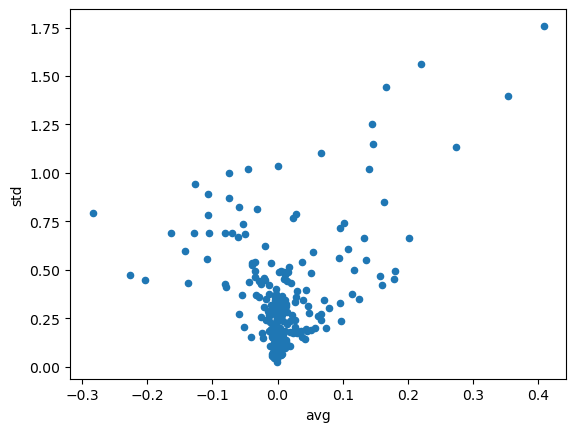

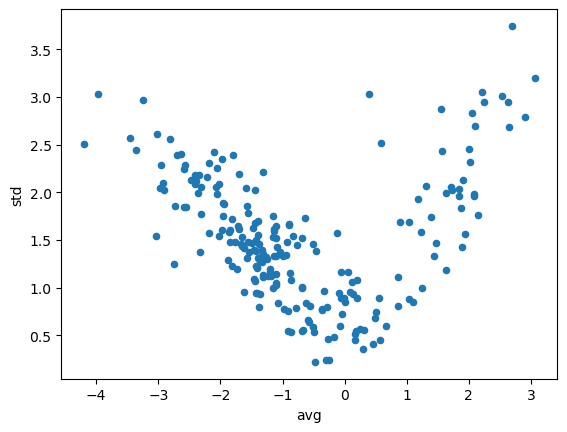

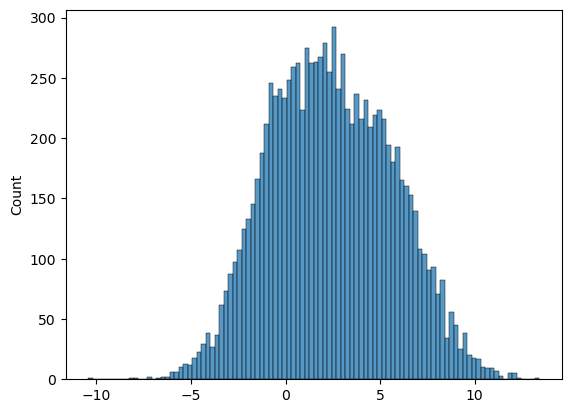

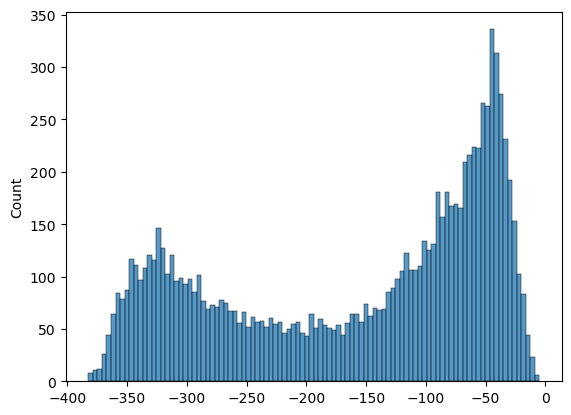

In [60]:
def get_attr_from_records(records, attributor_name, y_true):
    """Get the attributions for a given attributor and y_true."""
    attr = np.stack(
        list(map(
            lambda x: np.array(x[attributor_name]).reshape((11, 20)),
            filter(lambda x: x["y_true"] in y_true, records)
        )))
        
    return attr

def get_onehotstack_from_records(records, y_true = (0, 1)):
    """Get the onehot stack from the records."""
    slides = [record["slide"] for record in records if record["y_true"] in y_true]
    onehots = [preprocessing.onehot_encode(slide) for slide in slides]
    onehot_stack = np.stack(onehots)
    return onehot_stack


def get_df_stats_from_records(records, attributor_name: str, y_true = (0, 1), sequence_aa_only = False):
    """Get a dataframe with the mean and std of the attributions for each amino acid:index feature."""
    attr = get_attr_from_records(records, attributor_name, y_true)

    if sequence_aa_only:
        onehot_stack = get_onehotstack_from_records(records, y_true)
        attr = attr * onehot_stack.reshape((-1, 11, 20))
        # Replace 0 with NaNs
        attr[attr == 0] = np.nan

    # attr_avg = attr.mean(axis=0).reshape(-1)
    # attr_std = attr.std(axis=0).reshape(-1)
    attr_avg = np.nanmean(attr, axis=0).reshape(-1)
    attr_std = np.nanstd(attr, axis=0).reshape(-1)

    df = pd.DataFrame({"avg": attr_avg, "std": attr_std})
    return df

def get_attr_sums_from_records(records, attributor_name: str, y_true = (0, 1)):
    """Sum of all attributions for each record."""
    attr = get_attr_from_records(records, attributor_name, y_true)
    attr_sum = attr.reshape((-1, 11*20)).sum(axis=1)
    return attr_sum

def get_attr_onehotsum_from_records(records, attributor_name: str, y_true = (0, 1)):
    """Sum of attributions only for the amino acid in the sequence."""
    attr = get_attr_from_records(records, attributor_name, y_true)
    onehot_stack = get_onehotstack_from_records(records)
    attr_reshaped = attr.reshape((-1, 11*20))
    onehotsum = (attr_reshaped * onehot_stack).sum(axis=1)
    return onehotsum


## Stats
# df_local = get_df_stats_from_records(records, 'DeepLIFT_LOCAL_v2.0-2', y_true=(1,))
# df_global = get_df_stats_from_records(records, 'DeepLIFT_GLOBAL_R10_v2.0-2', y_true=(1,))
df_local = get_df_stats_from_records(records, 'DeepLIFT_LOCAL_v2.0-2', y_true=(0, 1))
df_global = get_df_stats_from_records(records, 'DeepLIFT_GLOBAL_R10_v2.0-2', y_true=(0, 1))

df_local.plot.scatter(x="avg", y="std")
plt.show()
df_global.plot.scatter(x="avg", y="std")
plt.show()


## Sums
sums_local = get_attr_sums_from_records(records, 'DeepLIFT_LOCAL_v2.0-2', y_true=(0, 1))
sums_global = get_attr_sums_from_records(records, 'DeepLIFT_GLOBAL_R10_v2.0-2', y_true=(0, 1))
sns.histplot(sums_local, bins=100)
plt.show()
sns.histplot(sums_global, bins=100)
plt.show()

onehot_sums_local = get_attr_onehotsum_from_records(records, 'DeepLIFT_LOCAL_v2.0-2', y_true=(0, 1))
onehot_sums_global = get_attr_onehotsum_from_records(records, 'DeepLIFT_GLOBAL_R10_v2.0-2', y_true=(0, 1))

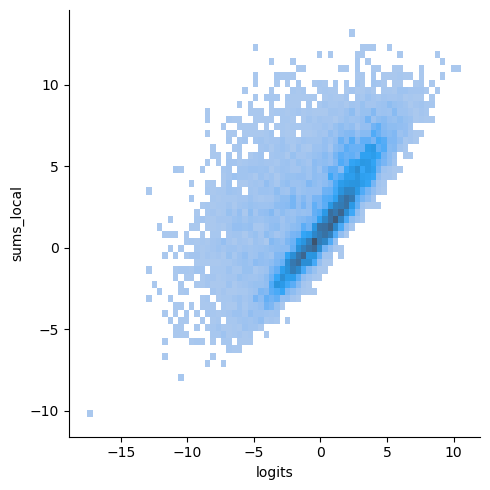

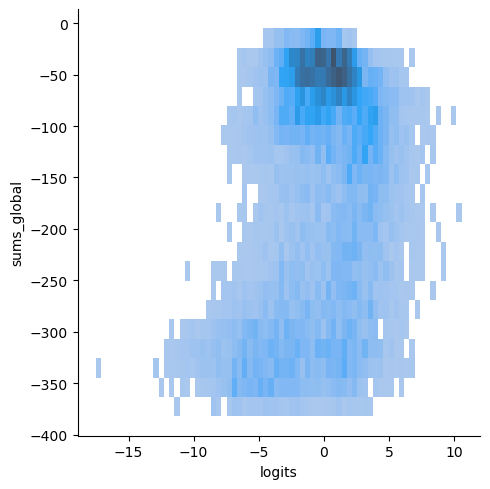

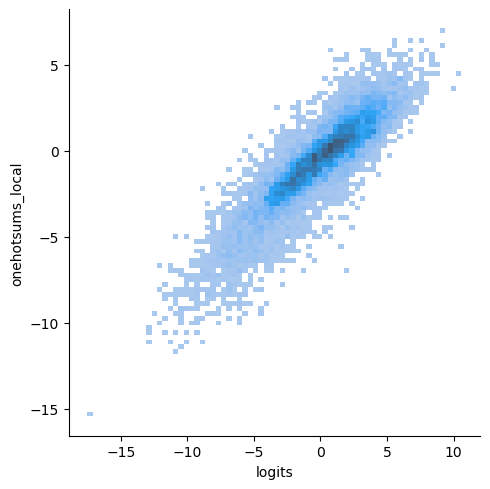

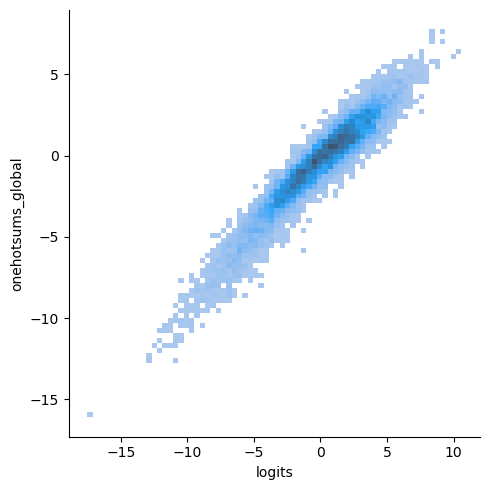

In [49]:
df = pd.DataFrame.from_records(records)
df["sums_local"] = sums_local
df["sums_global"] = sums_global
df["onehotsums_local"] = onehot_sums_local
df["onehotsums_global"] = onehot_sums_global

# sns.scatterplot(data=df, x="sums_local", y="sums_global")
# sns.scatterplot(data=df, x="sums_local", y="sums_global", hue="y_true")
sns.displot(data=df, x="logits", y="sums_local")
plt.show()
sns.displot(data=df, x="logits", y="sums_global")
plt.show()
sns.displot(data=df, x="logits", y="onehotsums_local")
plt.show()
sns.displot(data=df, x="logits", y="onehotsums_global")
plt.show()

Distributions of IG per aminoacid:index pair that is actually in the sequence
- We have some "consistent" amino acids, i.e. amino acids that if present, have a strong IG with low variability.
- Further investigation of this?

/tmp/ipykernel_2156491/3800362027.py:31: RuntimeWarning: Mean of empty slice
  attr_avg = np.nanmean(attr, axis=0).reshape(-1)
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2156491/3800362027.py:31: RuntimeWarning: Mean of empty slice
  attr_avg = np.nanmean(attr, axis=0).reshape(-1)
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2156491/3800362027.py:31: RuntimeWarning: Mean of empty slice
  attr_avg = np.nanmean(attr, axis=0).reshape(-1)
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp

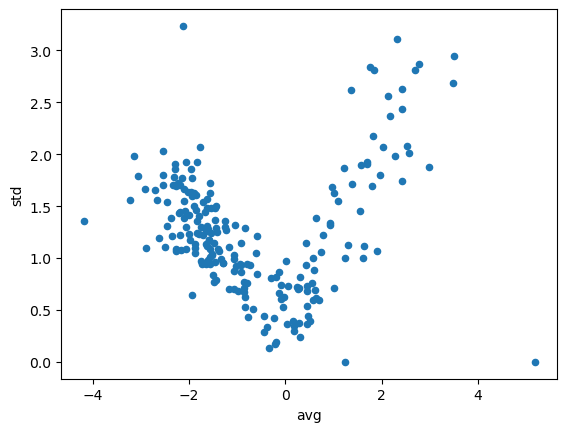

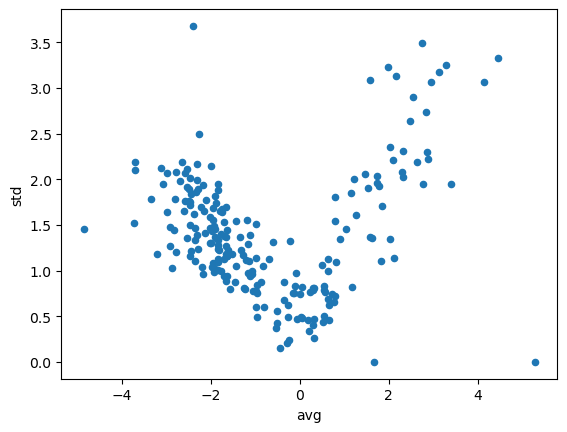

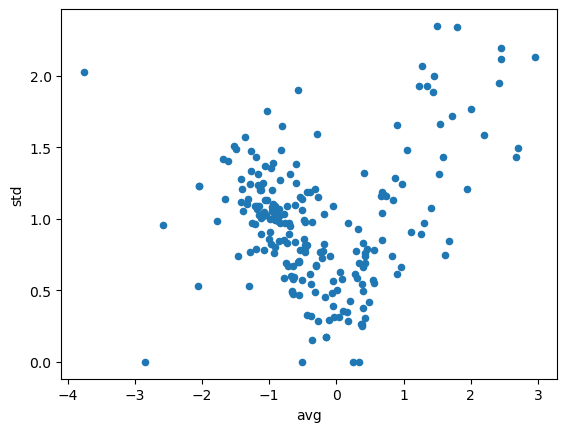

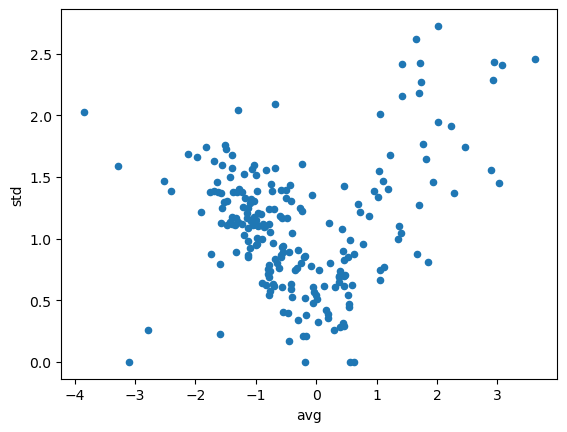

In [63]:
df_local_0 = get_df_stats_from_records(records, 'DeepLIFT_LOCAL_v2.0-2', y_true=(0,), sequence_aa_only=True)
df_global_0 = get_df_stats_from_records(records, 'DeepLIFT_GLOBAL_R10_v2.0-2', y_true=(0,), sequence_aa_only=True)

df_local_1 = get_df_stats_from_records(records, 'DeepLIFT_LOCAL_v2.0-2', y_true=(1,), sequence_aa_only=True)
df_global_1 = get_df_stats_from_records(records, 'DeepLIFT_GLOBAL_R10_v2.0-2', y_true=(1,), sequence_aa_only=True)

df_local_0.plot.scatter(x="avg", y="std")
plt.show()
df_global_0.plot.scatter(x="avg", y="std")
plt.show()
df_local_1.plot.scatter(x="avg", y="std")
plt.show()
df_global_1.plot.scatter(x="avg", y="std")
plt.show()